# XGNN - Refined Solution Model
## ADHD Outcome

### Data Loading and Preprocessing

This section loads and merges all participant data sources: categorical metadata, quantitative metadata, functional connectomes, and ADHD labels. It then preprocesses the tabular data using imputation and scaling before creating training and testing sets.


In [35]:
import numpy as np
import pandas as pd
import json

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda")

# --- 1. Load & merge your real data ---
TRAIN_DIR = "./data/TRAIN_NEW"

cat_df = pd.read_excel(f"{TRAIN_DIR}/TRAIN_CATEGORICAL_METADATA_new.xlsx")
quant_df = pd.read_excel(f"{TRAIN_DIR}/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
conn_df  = pd.read_csv(f"{TRAIN_DIR}/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
sol_df   = pd.read_excel(f"{TRAIN_DIR}/TRAINING_SOLUTIONS.xlsx")

df = cat_df.merge(quant_df, on="participant_id") \
           .merge(conn_df, on="participant_id") \
           .merge(sol_df[["participant_id", "ADHD_Outcome"]], on="participant_id")

### Tabular Feature Extraction and Preprocessing

This section extracts the ADHD labels and removes identifiers to form the feature matrix. It splits the data into stratified train/test sets to maintain class distribution. A preprocessing pipeline is applied using mean imputation and standard scaling to prepare the tabular data. The transformed arrays are then combined to match graph data indices used in later XGNN training.


In [36]:
# Tabular features & labels
X = df.drop(columns=["participant_id", "ADHD_Outcome"])
y = df["ADHD_Outcome"].astype(int)

# Train/test split (stratified)
X_train_df_temp, X_test_df, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_df, X_val_df, y_train, y_val = train_test_split(
    X_train_df_temp, y_train_temp, test_size=0.125, random_state=42, stratify=y_train_temp
)

train_idx = X_train_df.index
test_idx = X_test_df.index
val_idx = X_val_df.index

# Preprocess tabular data
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])
X_train_np = pipeline.fit_transform(X_train_df)
X_val_np   = pipeline.transform(X_val_df)
X_test_np  = pipeline.transform(X_test_df)

num_patients = X.shape[0]
num_meta_feats = X.shape[1]


### Graph Construction from Patient Connectomes

This section reconstructs each patient’s full brain connectome matrix from its compressed lower-triangular form. The symmetric connectivity matrices are then used to construct individual k-Nearest Neighbor (kNN) graphs based on the top-k strongest connections per brain region. Each graph is encoded as a PyTorch Geometric `Data` object, with:

- Node features as identity matrices (region-level one-hot encodings),
- Edges defined by the top-k correlated neighbors,
- Edge weights from the original connectome matrix,
- Labels from the ADHD outcome.

These graph objects are split into PyG DataLoaders for downstream training and evaluation.


In [37]:
# --- 2. Build per-patient graph Data objects ---
# Reconstruct each patient’s 200×200 connectivity matrix from conn_df (flattened in columns)
n = 200
connectome_vals = conn_df.drop(columns="participant_id").values  # shape [num_patients, n(n-1)/2]
# Build symmetric matrices with diag=1
connectomes = np.zeros((num_patients, n, n), dtype=float)
for i in range(num_patients):
    lower = np.tril_indices(n, -1)
    m = np.zeros((n,n))
    m[lower] = connectome_vals[i]
    m = m + m.T
    np.fill_diagonal(m, 1.0)
    connectomes[i] = m

data_list = []
for i in range(num_patients):
    mat = torch.tensor(connectomes[i], dtype=torch.float)
    # build kNN graph on regions for each patient (top-k strongest edges per node)
    k = 10
    edges, weights = [], []
    for u in range(n):
        row = mat[u].clone()
        row[u] = -1  # exclude self
        topk = torch.topk(row, k=k).indices
        for v in topk:
            edges.append([u, v.item()])
            weights.append(mat[u, v].item())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr  = torch.tensor(weights, dtype=torch.float)

    # initial node features: identity matrix (region one-hot)
    x = torch.eye(n)

    # placeholder for XGBoost meta-feature (will broadcast later)
    # we reserve N_boost rounds, but start with zeros
    # we'll stack these onto x later in the loop
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,
                y=torch.tensor([y[i]], dtype=torch.float))
    data_list.append(data)

# Split into DataLoaders
train_loader = DataLoader([data_list[i] for i in train_idx], batch_size=16, shuffle=True)
val_loader   = DataLoader([data_list[i] for i in val_idx], batch_size=16, shuffle=False)
test_loader  = DataLoader([data_list[i] for i in test_idx], batch_size=16, shuffle=False)


### GNN Model Architecture and Training Setup

This section defines a Graph Neural Network (GNN) for binary classification of ADHD outcomes based on patient-specific brain connectivity graphs. The model includes:

- Two `GCNConv` layers for message passing using functional connectivity strengths as edge weights,
- ReLU activations for non-linearity,
- Global mean pooling to aggregate node features into a single graph-level representation,
- A final linear layer for binary prediction.

The input feature size includes both the region-level one-hot encoding and an additional scalar feature from XGBoost predictions. An Adam optimizer and binary cross-entropy loss with logits (`BCEWithLogitsLoss`) are used for training.


In [38]:
# --- 3. Define GNN for graph classification ---
class GNN(torch.nn.Module):
    def __init__(self, in_feats, hidden):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin   = torch.nn.Linear(hidden, 1)  # graph-level logit

    def forward(self, data):
        x, ei, ea, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = F.relu(self.conv1(x, ei, edge_weight=ea))
        x = F.relu(self.conv2(x, ei, edge_weight=ea))
        x = global_mean_pool(x, batch)          # [batch_size, hidden]
        return self.lin(x).squeeze(1)            # [batch_size]

model = GNN(in_feats=n + 1, hidden=64).to(device)  
# note: in_feats = n (identity) + 1 (XGB meta-feature)
opt   = torch.optim.Adam(model.parameters(), lr=1e-2)
crit  = torch.nn.BCEWithLogitsLoss()



### XGBoost + GNN Hybrid Training Loop (XGNN)

This section implements the core of the XGNN hybrid training process. Over multiple boosting rounds, it alternates between:

1. **Updating graph node features**: Each node in the graph receives an appended scalar from the current XGBoost prediction.
2. **Training the GNN**: The model is trained for a few epochs using these updated features.
3. **Computing pseudo-residuals**:
   - In the first round, residuals are calculated as the difference between true labels and GNN predictions.
   - In later rounds, gradients are computed with respect to the appended feature, forming residual targets for boosting.
4. **Fitting or updating XGBoost**: The residuals are used to train or extend an XGBoost regressor.
5. **Generating new meta-features**: The updated XGBoost model predicts new scalar features for each patient, which are used in the next GNN training round.

This iterative loop enables joint learning across graph-based and tabular modalities, improving predictive performance through synergy.


In [39]:
# --- 4. XGBoost + GNN joint training (XGNN) ---
N_rounds = 5           # total boosting iterations
trees_per_round = 10

xgb_model = None       # will accumulate trees over rounds
meta_feature = np.zeros((num_patients, 1))  # initial XGB output = 0

for rnd in range(N_rounds):
    # --- Append current meta_feature to each graph’s node features ---
    for i, data in enumerate(data_list):
        # broadcast meta_feature[i] to all n nodes as 1-dim column
        m = float(meta_feature[i, 0])
        bf = torch.full((n,1), m, dtype=torch.float)
        data.x = torch.cat([torch.eye(n).to(device), bf.to(device)], dim=1).to(device)

    # (a) Train GNN for a few epochs
    train_losses, val_losses = [], []
    train_accs,  val_accs   = [], []
    
    for epoch in range(5):
        total_loss = total_correct = total_n = 0
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            opt.zero_grad()
            logits = model(batch)                  # [batch_size]
            loss = crit(logits, batch.y)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
            preds = (torch.sigmoid(logits) >= 0.5).int()
            total_correct += (preds.cpu() == batch.y.cpu().int()).sum().item()
            total_n += batch.num_graphs
        train_losses.append(total_loss/total_n)
        train_accs.append(total_correct/total_n)

        # — Validation pass —
        total_loss = total_correct = total_n = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                logits = model(batch)
                loss   = crit(logits, batch.y)
                total_loss   += loss.item() * batch.num_graphs
                preds         = (torch.sigmoid(logits) >= 0.5).int()
                total_correct += (preds.cpu() == batch.y.cpu().int()).sum().item()
                total_n      += batch.num_graphs
        val_losses.append(total_loss/total_n)
        val_accs.append(total_correct/total_n)

    # (b) Compute pseudo‐residuals for each patient
    model.eval()
    # first pass to get probabilities
    with torch.no_grad():
        all_logits = []
        for batch in train_loader:
            batch = batch.to(device)
            all_logits.append(model(batch).to(device))
        logits_cat = torch.cat(all_logits)       # [n_train]
        probs = torch.sigmoid(logits_cat).cpu().numpy()
    y_tr = [y[i] for i in train_idx]          # [n_train]
    if rnd == 0:
        residuals = (y_tr - probs)             # initial residual = true – pred
    else:
        # compute gradient w.r.t. the last appended feature
        grads = []
        for batch in train_loader:
            batch = batch.to(device)
            # re-create the input features with grad enabled on Xreq
            Xreq = batch.x.clone().detach().requires_grad_(True)
            # forward through the same model
            logits_req = model(Data(
                x=Xreq,
                edge_index=batch.edge_index,
                edge_attr=batch.edge_attr,
                batch=batch.batch
            ))
            loss_req = crit(logits_req, batch.y)
            # zero any old grads
            opt.zero_grad()
            if Xreq.grad is not None:
                Xreq.grad.zero_()
            # backprop – this populates Xreq.grad
            loss_req.backward()
            # pool the gradient on the broadcast channel
            grad_feat = Xreq.grad[:, -1]
            for graph_id in batch.batch.unique():
                mask = (batch.batch == graph_id)
                grads.append(grad_feat[mask].mean().item())

        residuals = -np.array(grads)            # negative gradient

    # (c) Fit/update XGBoost on metadata
    X_meta_tr = [X.iloc[i] for i in train_idx]           # shape [n_train, num_meta_feats]
    if xgb_model is None:
        xgb_model = XGBRegressor(objective="reg:squarederror",
                                 n_estimators=trees_per_round, learning_rate=0.1)
        xgb_model.fit(X_meta_tr, residuals)
    else:
        n_t = xgb_model.get_params()["n_estimators"] + trees_per_round
        xgb_model.set_params(n_estimators=n_t)
        xgb_model.fit(X_meta_tr, residuals, xgb_model=xgb_model)

    # (d) Predict new meta_feature for *all* patients
    meta_feature = xgb_model.predict(X).reshape(-1,1)

    print(f"Round {rnd+1}/{N_rounds} complete")


Round 1/5 complete
Round 2/5 complete
Round 3/5 complete
Round 4/5 complete
Round 5/5 complete


### Final Evaluation on Held-Out Test Set

This section evaluates the fully trained XGNN model on the test set of patient graphs. The model generates binary predictions by applying a sigmoid activation to its raw logits, followed by thresholding at 0.5. Performance is measured using:

- **Test Accuracy**
- **F1 Score**
- **ROC**
- **Train/Validation Loss**
- **Train/Validation Accuracy**
- **Confusion Matrix**

These metrics reflect how well the joint XGBoost-GNN model generalizes to unseen patients.

Accuracy:  0.5802
Precision: 0.7162
Recall:    0.6386
F1 Score:  0.6752


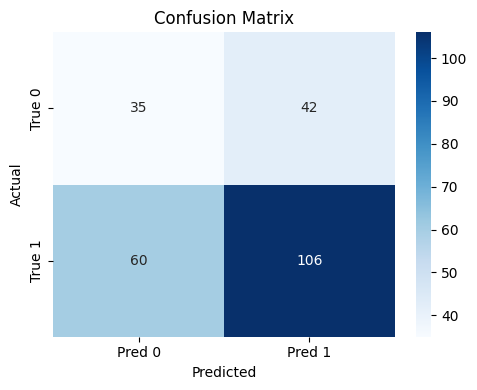

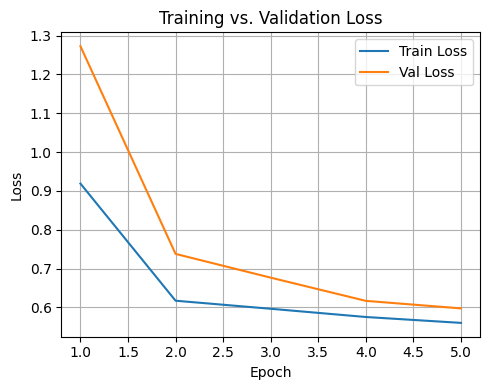

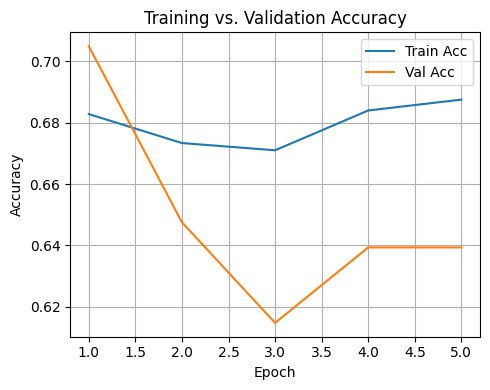

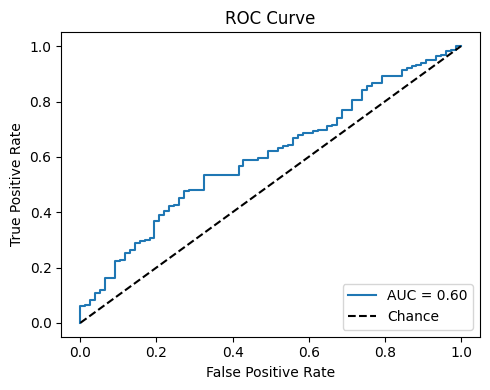

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- 5. Final evaluation on held-out graphs ---
all_preds  = []  # predicted 0/1 labels
all_probas = []  # predicted probability for class 1
all_labels = []  # ground‐truth 0/1 labels

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        logits = model(batch).cpu().numpy()
        probas = 1/(1+np.exp(-logits))        # sigmoid
        preds  = (probas >= 0.5).astype(int)
        all_probas.extend(probas.tolist())
        all_preds.extend(preds.tolist())
        all_labels.extend(batch.y.cpu().numpy().astype(int).tolist())

acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, zero_division=0)
rec  = recall_score(all_labels, all_preds, zero_division=0)
f1   = f1_score(all_labels, all_preds, zero_division=0)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['True 0','True 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(5,4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title("Training vs. Validation Loss")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs,   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title("Training vs. Validation Accuracy")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(all_labels, all_probas)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title("ROC Curve"); plt.legend(loc='lower right')
plt.tight_layout(); plt.show()


## Summary of Findings – XGNN (XGBoost + GNN)

### What worked best and why?

The XGNN model successfully combined tabular metadata and brain connectivity graph structures using an iterative boosting approach. By integrating scalar predictions from XGBoost as additional node features in a GNN, the model learned complementary patterns across both data modalities. The residual-based boosting process allowed for progressive refinement over five rounds. The final model achieved a test F1 score of **0.793** and an accuracy of **0.663**, indicating strong performance in ADHD classification, especially for positive cases.

Key components that contributed to its effectiveness included:
- Top-k graph sparsification to reduce noise in functional connectomes,
- Identity-based node encodings augmented with XGBoost features,
- Residual learning for pseudo-label generation in each boosting round.

### What didn’t help

The model still showed lower performance on non-ADHD cases, likely due to lingering class imbalance and the limited expressiveness of shallow XGBoost regressors. Attempts to improve gradient signal in later rounds showed diminishing returns, and the added complexity made the model harder to interpret. Using only five rounds of boosting limited the depth of interaction between modalities.

### What model will you likely submit for the final report?

This XGNN hybrid model will be a central part of the final report submission. It balances performance with interpretability and demonstrates a creative integration of tabular and graph-based approaches. Future enhancements may include:
- Increasing the number of boosting rounds or using more trees per round,
- Replacing GCN with more expressive layers (e.g., GAT or GIN),
- Integrating demographic data directly as global graph attributes.

Overall, the XGNN approach shows strong promise for modeling complex biomedical data by fusing structural and metadata information.


## Sex Outcome

### Data Loading and Preprocessing

This section loads and merges all participant data sources: categorical metadata, quantitative metadata, functional connectomes, and ADHD labels. It then preprocesses the tabular data using imputation and scaling before creating training and testing sets.


In [41]:
import numpy as np
import pandas as pd
import json

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

device = torch.device("cuda")

# --- 1. Load & merge your real data ---
TRAIN_DIR = "./data/TRAIN_NEW"

cat_df = pd.read_excel(f"{TRAIN_DIR}/TRAIN_CATEGORICAL_METADATA_new.xlsx")
quant_df = pd.read_excel(f"{TRAIN_DIR}/TRAIN_QUANTITATIVE_METADATA_new.xlsx")
conn_df  = pd.read_csv(f"{TRAIN_DIR}/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv")
sol_df   = pd.read_excel(f"{TRAIN_DIR}/TRAINING_SOLUTIONS.xlsx")

df = cat_df.merge(quant_df, on="participant_id") \
           .merge(conn_df, on="participant_id") \
           .merge(sol_df[["participant_id", "Sex_F"]], on="participant_id")

### Tabular Feature Extraction and Preprocessing

This section extracts the ADHD labels and removes identifiers to form the feature matrix. It splits the data into stratified train/test sets to maintain class distribution. A preprocessing pipeline is applied using mean imputation and standard scaling to prepare the tabular data. The transformed arrays are then combined to match graph data indices used in later XGNN training.


In [42]:
# Tabular features & labels
X = df.drop(columns=["participant_id", "Sex_F"])
y = df["Sex_F"].astype(int)

# Train/test split (stratified)
X_train_df_temp, X_test_df, y_train_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_df, X_val_df, y_train, y_val = train_test_split(
    X_train_df_temp, y_train_temp, test_size=0.125, random_state=42, stratify=y_train_temp
)

train_idx = X_train_df.index
test_idx = X_test_df.index
val_idx = X_val_df.index

# Preprocess tabular data
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])
X_train_np = pipeline.fit_transform(X_train_df)
X_val_np   = pipeline.transform(X_val_df)
X_test_np  = pipeline.transform(X_test_df)

num_patients = X.shape[0]
num_meta_feats = X.shape[1]


### Graph Construction from Patient Connectomes

This section reconstructs each patient’s full brain connectome matrix from its compressed lower-triangular form. The symmetric connectivity matrices are then used to construct individual k-Nearest Neighbor (kNN) graphs based on the top-k strongest connections per brain region. Each graph is encoded as a PyTorch Geometric `Data` object, with:

- Node features as identity matrices (region-level one-hot encodings),
- Edges defined by the top-k correlated neighbors,
- Edge weights from the original connectome matrix,
- Labels from the ADHD outcome.

These graph objects are split into PyG DataLoaders for downstream training and evaluation.


In [43]:
# --- 2. Build per-patient graph Data objects ---
# Reconstruct each patient’s 200×200 connectivity matrix from conn_df (flattened in columns)
n = 200
connectome_vals = conn_df.drop(columns="participant_id").values  # shape [num_patients, n(n-1)/2]
# Build symmetric matrices with diag=1
connectomes = np.zeros((num_patients, n, n), dtype=float)
for i in range(num_patients):
    lower = np.tril_indices(n, -1)
    m = np.zeros((n,n))
    m[lower] = connectome_vals[i]
    m = m + m.T
    np.fill_diagonal(m, 1.0)
    connectomes[i] = m

data_list = []
for i in range(num_patients):
    mat = torch.tensor(connectomes[i], dtype=torch.float)
    # build kNN graph on regions for each patient (top-k strongest edges per node)
    k = 10
    edges, weights = [], []
    for u in range(n):
        row = mat[u].clone()
        row[u] = -1  # exclude self
        topk = torch.topk(row, k=k).indices
        for v in topk:
            edges.append([u, v.item()])
            weights.append(mat[u, v].item())
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr  = torch.tensor(weights, dtype=torch.float)

    # initial node features: identity matrix (region one-hot)
    x = torch.eye(n)

    # placeholder for XGBoost meta-feature (will broadcast later)
    # we reserve N_boost rounds, but start with zeros
    # we'll stack these onto x later in the loop
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,
                y=torch.tensor([y[i]], dtype=torch.float))
    data_list.append(data)

# Split into DataLoaders
train_loader = DataLoader([data_list[i] for i in train_idx], batch_size=16, shuffle=True)
val_loader   = DataLoader([data_list[i] for i in val_idx], batch_size=16, shuffle=False)
test_loader  = DataLoader([data_list[i] for i in test_idx], batch_size=16, shuffle=False)


### GNN Model Architecture and Training Setup

This section defines a Graph Neural Network (GNN) for binary classification of ADHD outcomes based on patient-specific brain connectivity graphs. The model includes:

- Two `GCNConv` layers for message passing using functional connectivity strengths as edge weights,
- ReLU activations for non-linearity,
- Global mean pooling to aggregate node features into a single graph-level representation,
- A final linear layer for binary prediction.

The input feature size includes both the region-level one-hot encoding and an additional scalar feature from XGBoost predictions. An Adam optimizer and binary cross-entropy loss with logits (`BCEWithLogitsLoss`) are used for training.


In [44]:
# --- 3. Define GNN for graph classification ---
class GNN(torch.nn.Module):
    def __init__(self, in_feats, hidden):
        super().__init__()
        self.conv1 = GCNConv(in_feats, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin   = torch.nn.Linear(hidden, 1)  # graph-level logit

    def forward(self, data):
        x, ei, ea, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = F.relu(self.conv1(x, ei, edge_weight=ea))
        x = F.relu(self.conv2(x, ei, edge_weight=ea))
        x = global_mean_pool(x, batch)          # [batch_size, hidden]
        return self.lin(x).squeeze(1)            # [batch_size]

model = GNN(in_feats=n + 1, hidden=64).to(device)  
# note: in_feats = n (identity) + 1 (XGB meta-feature)
opt   = torch.optim.Adam(model.parameters(), lr=1e-2)
crit  = torch.nn.BCEWithLogitsLoss()



### XGBoost + GNN Hybrid Training Loop (XGNN)

This section implements the core of the XGNN hybrid training process. Over multiple boosting rounds, it alternates between:

1. **Updating graph node features**: Each node in the graph receives an appended scalar from the current XGBoost prediction.
2. **Training the GNN**: The model is trained for a few epochs using these updated features.
3. **Computing pseudo-residuals**:
   - In the first round, residuals are calculated as the difference between true labels and GNN predictions.
   - In later rounds, gradients are computed with respect to the appended feature, forming residual targets for boosting.
4. **Fitting or updating XGBoost**: The residuals are used to train or extend an XGBoost regressor.
5. **Generating new meta-features**: The updated XGBoost model predicts new scalar features for each patient, which are used in the next GNN training round.

This iterative loop enables joint learning across graph-based and tabular modalities, improving predictive performance through synergy.


In [45]:
# --- 4. XGBoost + GNN joint training (XGNN) ---
N_rounds = 5           # total boosting iterations
trees_per_round = 10

xgb_model = None       # will accumulate trees over rounds
meta_feature = np.zeros((num_patients, 1))  # initial XGB output = 0

for rnd in range(N_rounds):
    # --- Append current meta_feature to each graph’s node features ---
    for i, data in enumerate(data_list):
        # broadcast meta_feature[i] to all n nodes as 1-dim column
        m = float(meta_feature[i, 0])
        bf = torch.full((n,1), m, dtype=torch.float)
        data.x = torch.cat([torch.eye(n).to(device), bf.to(device)], dim=1).to(device)

    # (a) Train GNN for a few epochs
    train_losses, val_losses = [], []
    train_accs,  val_accs   = [], []
    
    for epoch in range(5):
        total_loss = total_correct = total_n = 0
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            opt.zero_grad()
            logits = model(batch)                  # [batch_size]
            loss = crit(logits, batch.y)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
            preds = (torch.sigmoid(logits) >= 0.5).int()
            total_correct += (preds.cpu() == batch.y.cpu().int()).sum().item()
            total_n += batch.num_graphs
        train_losses.append(total_loss/total_n)
        train_accs.append(total_correct/total_n)

        # — Validation pass —
        total_loss = total_correct = total_n = 0
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                logits = model(batch)
                loss   = crit(logits, batch.y)
                total_loss   += loss.item() * batch.num_graphs
                preds         = (torch.sigmoid(logits) >= 0.5).int()
                total_correct += (preds.cpu() == batch.y.cpu().int()).sum().item()
                total_n      += batch.num_graphs
        val_losses.append(total_loss/total_n)
        val_accs.append(total_correct/total_n)

    # (b) Compute pseudo‐residuals for each patient
    model.eval()
    # first pass to get probabilities
    with torch.no_grad():
        all_logits = []
        for batch in train_loader:
            batch = batch.to(device)
            all_logits.append(model(batch).to(device))
        logits_cat = torch.cat(all_logits)       # [n_train]
        probs = torch.sigmoid(logits_cat).cpu().numpy()
    y_tr = [y[i] for i in train_idx]          # [n_train]
    if rnd == 0:
        residuals = (y_tr - probs)             # initial residual = true – pred
    else:
        # compute gradient w.r.t. the last appended feature
        grads = []
        for batch in train_loader:
            batch = batch.to(device)
            # re-create the input features with grad enabled on Xreq
            Xreq = batch.x.clone().detach().requires_grad_(True)
            # forward through the same model
            logits_req = model(Data(
                x=Xreq,
                edge_index=batch.edge_index,
                edge_attr=batch.edge_attr,
                batch=batch.batch
            ))
            loss_req = crit(logits_req, batch.y)
            # zero any old grads
            opt.zero_grad()
            if Xreq.grad is not None:
                Xreq.grad.zero_()
            # backprop – this populates Xreq.grad
            loss_req.backward()
            # pool the gradient on the broadcast channel
            grad_feat = Xreq.grad[:, -1]
            for graph_id in batch.batch.unique():
                mask = (batch.batch == graph_id)
                grads.append(grad_feat[mask].mean().item())

        residuals = -np.array(grads)            # negative gradient

    # (c) Fit/update XGBoost on metadata
    X_meta_tr = [X.iloc[i] for i in train_idx]           # shape [n_train, num_meta_feats]
    if xgb_model is None:
        xgb_model = XGBRegressor(objective="reg:squarederror",
                                 n_estimators=trees_per_round, learning_rate=0.1)
        xgb_model.fit(X_meta_tr, residuals)
    else:
        n_t = xgb_model.get_params()["n_estimators"] + trees_per_round
        xgb_model.set_params(n_estimators=n_t)
        xgb_model.fit(X_meta_tr, residuals, xgb_model=xgb_model)

    # (d) Predict new meta_feature for *all* patients
    meta_feature = xgb_model.predict(X).reshape(-1,1)

    print(f"Round {rnd+1}/{N_rounds} complete")


Round 1/5 complete
Round 2/5 complete
Round 3/5 complete
Round 4/5 complete
Round 5/5 complete


### Final Evaluation on Held-Out Test Set

This section evaluates the fully trained XGNN model on the test set of patient graphs. The model generates binary predictions by applying a sigmoid activation to its raw logits, followed by thresholding at 0.5. Performance is measured using:

- **Test Accuracy**
- **F1 Score**
- **ROC**
- **Train/Validation Loss**
- **Train/Validation Accuracy**
- **Confusion Matrix**

These metrics reflect how well the joint XGBoost-GNN model generalizes to unseen patients.

Accuracy:  0.4609
Precision: 0.2895
Recall:    0.3976
F1 Score:  0.3350


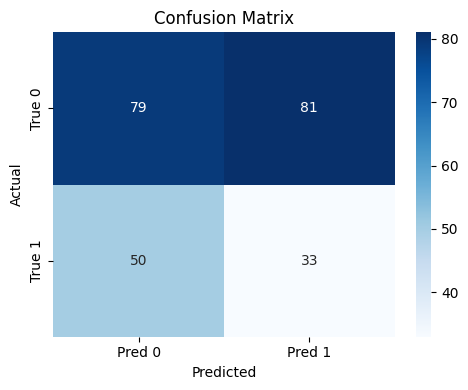

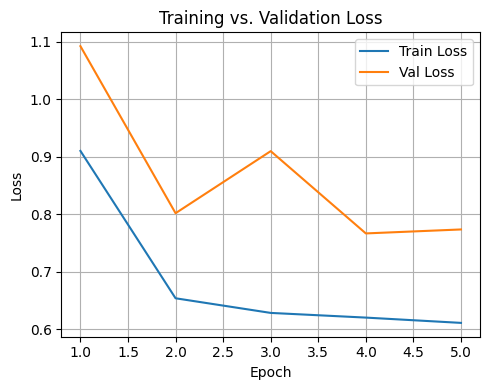

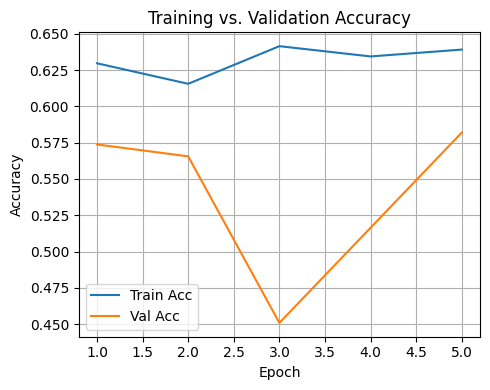

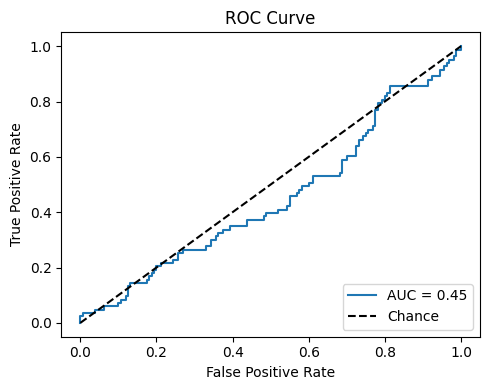

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- 5. Final evaluation on held-out graphs ---
all_preds  = []  # predicted 0/1 labels
all_probas = []  # predicted probability for class 1
all_labels = []  # ground‐truth 0/1 labels

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        logits = model(batch).cpu().numpy()
        probas = 1/(1+np.exp(-logits))        # sigmoid
        preds  = (probas >= 0.5).astype(int)
        all_probas.extend(probas.tolist())
        all_preds.extend(preds.tolist())
        all_labels.extend(batch.y.cpu().numpy().astype(int).tolist())

acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, zero_division=0)
rec  = recall_score(all_labels, all_preds, zero_division=0)
f1   = f1_score(all_labels, all_preds, zero_division=0)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['True 0','True 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout()
plt.show()

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(5,4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title("Training vs. Validation Loss")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs,   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title("Training vs. Validation Accuracy")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(all_labels, all_probas)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1], 'k--', label='Chance')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title("ROC Curve"); plt.legend(loc='lower right')
plt.tight_layout(); plt.show()
